# Chapter 16. Multitapers

In [26]:
import numpy as np
import scipy.io
from matplotlib import pyplot as plt

#import basic functions from numpy that we'll need
from numpy import pi, sin, cos, exp, sqrt, log, log10, random, angle, real, imag  
from numpy import zeros, ceil, floor, absolute, linspace
from numpy.fft import fft, ifft
from scipy import signal as sig
from scipy.signal.windows import dpss
from matplotlib.pyplot import *

Import EEG data

In [3]:
data = scipy.io.loadmat('sampleEEGdata')
EEGdata = data["EEG"][0,0]["data"]
EEGpnts = data["EEG"][0,0]["pnts"][0,0] #number of points in EEG data
EEGtimes = data["EEG"][0,0]["times"][0]
EEGsrate = float(data["EEG"][0,0]["srate"][0]) #make float for division purposes later
EEGtrials = data["EEG"][0,0]["trials"][0,0]
EEGnbchan = data["EEG"][0,0]["nbchan"][0,0]

EEGchanlocslabels=data["EEG"][0,0]["chanlocs"][0]["labels"]

### Figure 16.1

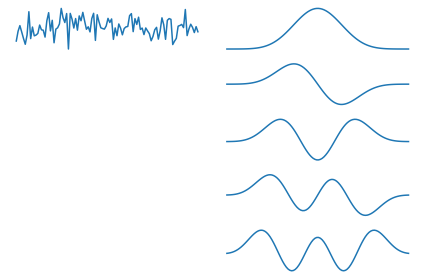

In [29]:

channel2plot = 'O1';
timewin      = 400. # in ms
timewinidx = int(np.round(timewin/(1000/EEGsrate)))


#use dpss taken from nitime library
tapers = dpss(M=timewinidx,NW=5,Kmax=5)

#extract a bit of EEG data
d = sig.detrend(np.squeeze(EEGdata[EEGchanlocslabels==channel2plot,199:199+timewinidx,9]))

#plot eeg data from snippet
subplot(521)
plot(d)
axis('off')
for ii in range(5):
    subplot(5,2,(2*ii)+2)
    plot(tapers[ii,:])
    axis('off')


tight_layout()

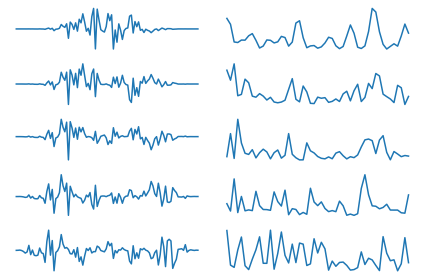

In [8]:
# plot taper*data

for ii in range(5):
    subplot(5,2,(2*(ii))+1)
    plot(tapers[ii,:]*d) #multiply data by tapers
    axis('off')

# plot fft of taper.*data
f=np.zeros([5,timewinidx]) * 1j

for ii in range(5):
    subplot(5,2,(2*(ii))+2)
    f[ii,:]=fft(tapers[ii,:]*d)
    plot(absolute(f[ii,:int(timewinidx/2)])**2)
    axis('off')
    
tight_layout()

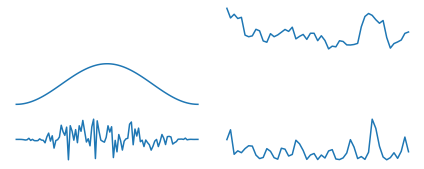

In [11]:
subplot(5,2,2)
plot(np.mean(absolute(f[:,:timewinidx//2])**2,axis=0))
axis('off')

subplot(523)
hann = .5*(1-cos(2*pi*np.arange(timewinidx)/(timewinidx-1)));
plot(hann)
axis('off')

subplot(525)
plot(hann*d)
axis('off')

subplot(526)
ff=fft(hann*d);
plot((absolute(ff[:timewinidx//2])**2))
axis('off')

tight_layout()

### Figure 16.2

In [24]:
channel2plot    = 'P7'
frequency2plot  = 15  # in Hz
timepoint2plot  = 200 # ms

nw_product      = 3 #  determines the frequency smoothing, given a specified time window
times2save      = np.arange(-300,1000+50,50)
baseline_range  = np.array([-200, -0])
timewin         = 400 # in ms

#define closest() to replace the use of Matlab's dsearchn() function

def closest(X, p):
    disp = X - p
    return np.argmin((disp*disp))

# convert time points to indices
times2saveidx = [closest(EEGtimes,x) for x in times2save]

timewinidx    = np.round(timewin/(1000/EEGsrate)).astype(int)

# find baselinetimepoints
baseidx = zeros(baseline_range.shape);

baseidx[0] = np.argmin(abs(times2save-baseline_range[0]))
baseidx[1] = np.argmin(abs(times2save-baseline_range[1]))

# define tapers
# note that in practice, you'll want to set the temporal resolution to be a function of frequency
tapers = dpss(timewinidx,nw_product,6)
#define frequencies for FFT
f = np.linspace(0,EEGsrate/2,(timewinidx//2)+1)

# find logical channel index
chanidx = EEGchanlocslabels ==channel2plot

#initialize output matrix
multitaper_tf = np.zeros([int(floor(timewinidx/2)+1),len(times2save)])

for ti in range(len(times2saveidx)):
    
    #init power vector (over tapers)
    taperpow = np.zeros(int(floor(timewinidx/2)+1)) * 1j
    
    #loop through tapers
    for tapi in range(1, tapers.shape[0]-1):
        
        #window and taper data, and get pwoer spectrum
        data = np.squeeze(EEGdata[chanidx, 
                                 int(times2saveidx[ti]-floor(timewinidx/2)):int(times2saveidx[ti]+ceil(timewinidx/2)),
                                 :])  
        #multiply by taper (Broadcasted)
        data *= np.reshape(tapers[tapi,:],[1,tapers.shape[1]]).T
        
        #compute power
        power = fft(data,n=timewinidx,axis=0)/timewinidx
        #take the real part
        power = power[:int(floor(timewinidx/2)+1),:]
        
        taperpow = taperpow + np.mean(power * np.conj(power),axis=1)
        #finally get power from closest frequency
        multitaper_tf[:,ti] = real(taperpow/tapi)
        
#db-correct
db_multitaper_tf = 10*log10( multitaper_tf
                            /np.tile(np.mean(multitaper_tf[:,int(baseidx[0]):int(baseidx[1])],axis=1),[len(times2save),1]).T)

[0.0, 40.0]

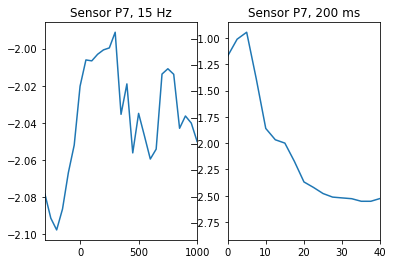

In [25]:
subplot(121)
freq2plotidx=np.argmin(absolute(f-frequency2plot))
_=plot(times2save,np.mean(log10(multitaper_tf[freq2plotidx-2:freq2plotidx+2,:]),axis=0))
title( 'Sensor ' + channel2plot + ', ' + str(frequency2plot) + ' Hz' )
xlim([times2save[0],times2save[-1]])

subplot(122)
time2plotidx =np.argmin(absolute(times2save-timepoint2plot));
plot(f,log10(multitaper_tf[:,time2plotidx]))
title( 'Sensor ' + channel2plot + ', ' + str(timepoint2plot) + ' ms' )
setp(gca(),'xlim',[f[0], 40])

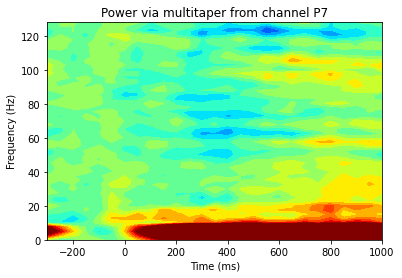

In [22]:
contourf(times2save,f,db_multitaper_tf,40,cmap=cm.jet)
xlabel('Time (ms)'), ylabel('Frequency (Hz)')
clim([-2,2])
_=title( 'Power via multitaper from channel ' + channel2plot )